<a href="https://colab.research.google.com/github/TairCohen/personal-nutritionist-agent/blob/main/LLava/LLaVa_model_for_calories_estimatation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade -q accelerate bitsandbytes
!pip install -q git+https://github.com/huggingface/transformers.git@v4.45.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.8 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/transformers.git (to revision v4.45.2) to /tmp/pip-req-build-ibm440u0
  Running comma

## Load model and processor

Next, we load a model and corresponding processor from the hub. We specify device_map="auto" in order to automatically place the model on the available GPUs/CPUs (see [this guide](https://huggingface.co/docs/accelerate/usage_guides/big_modeling) for details).

Regarding [quantization](https://huggingface.co/blog/4bit-transformers-bitsandbytes), refer to the blog post for all details.

In [ ]:
from transformers import AutoProcessor, LlavaForConditionalGeneration
from transformers import BitsAndBytesConfig
import torch

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

model_id = "llava-hf/llava-1.5-7b-hf"

processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(model_id, quantization_config=quantization_config, device_map="auto")

processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

Some kwargs in processor config are unused and will not have any effect: num_additional_image_tokens. 


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

## Prepare image and text for the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


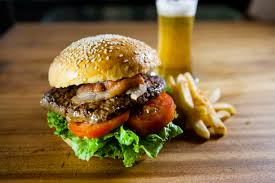

In [ ]:
import requests
from PIL import Image

image = Image.open("/content/drive/MyDrive/סיכומים מתואר שני/NLP/download.jpg")
# image = Image.open("/content/drive/MyDrive/סיכומים מתואר שני/NLP/salmon.jpg")
display(image)


In the prompt, you can refer to images using the special \<image> token. To indicate which text comes from a human vs. the model, one uses USER and ASSISTANT respectively. The format looks as follows:

```bash
USER: <image>\n<prompt>\nASSISTANT:
```

In other words, you always need to end your prompt with `ASSISTANT:`. Here we will perform batched generation (i.e generating on several prompts).

## Pipeline API

[pipeline](https://huggingface.co/docs/transformers/main_classes/pipelines)

In [ ]:
from transformers import pipeline

pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Set the patch_size and vision_feature_select_strategy attributes
pipe.tokenizer.patch_size = 14
pipe.tokenizer.vision_feature_select_strategy = 'grid'

In [ ]:
max_new_tokens = 1000

question =  ("Analyze this image of a dish and estimate the total number of calories. "
    "Identify the ingredients present, estimate their portion sizes, and calculate "
    "the approximate calorie content for each ingredient. Provide a detailed breakdown, including:\n"
    "1. A list of detected ingredients.\n"
    "2. Estimated weight or portion size of each ingredient.\n"
    "3. Caloric value per ingredient based on standard nutrition data.\n"
    "4. The total estimated calorie count for the dish.\n"
    "5. Any assumptions made in the estimation process.\n\n"
    "Justify your answer clearly, explaining how each ingredient contributes to the total calorie count.")
prompt = "USER: <image>\n" + question + "\nASSISTANT:"


outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": max_new_tokens})

In [ ]:
print(outputs[0]["generated_text"])

USER:  
Analyze this image of a dish and estimate the total number of calories. Identify the ingredients present, estimate their portion sizes, and calculate the approximate calorie content for each ingredient. Provide a detailed breakdown, including:
1. A list of detected ingredients.
2. Estimated weight or portion size of each ingredient.
3. Caloric value per ingredient based on standard nutrition data.
4. The total estimated calorie count for the dish.
5. Any assumptions made in the estimation process.

Justify your answer clearly, explaining how each ingredient contributes to the total calorie count.
ASSISTANT: The dish consists of a hamburger, tomatoes, lettuce, and french fries.

1. Hamburger: The hamburger is the main source of calories in the dish. It typically contains a combination of protein (from the meat patty), carbohydrates (from the bun), and fats (from the meat and any added condiments). The exact calorie count depends on the size of the patty, the type of meat used, a